# K-Means Clustering of Land Use Patterns in London

## Project Goal:
This project aims to classify London’s wards into spatially distinct groups based on detailed land use compositions using the K-Means clustering algorithm. By analyzing the percentage share of key land types—such as domestic buildings, greenspace, roads, and infrastructure—six distinct urban typologies are revealed, ranging from dense commercial cores to suburban residential zones and green corridors. These clusters are intended to provide valuable spatial insights for urban planning, land use policy, and neighborhood characterization across Greater London.

Data Source: London Datastore – Greater London Authority.
* [Land Use by Borough and Ward](https://data.london.gov.uk/dataset/land-use-ward)
* [2011 London Output Area Classification](https://data.london.gov.uk/dataset/london-area-classification)

## 1. Load and Explore the Dataset

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import geopandas as gpd

# Optional: Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Optional: Limit MKL threads to avoid memory warnings (Windows only)
os.environ["OMP_NUM_THREADS"] = "3"

In [2]:
# Load the dataset
df = pd.read_csv("land-use-glud-ward.csv")

In [3]:
# Display initial information
df.head()

,Area Code,Local Authority Name,Area name,Area of Domestic Buildings,Area of Domestic Gardens,Area of Non Domestic Buildings,Area of Road,Area of Rail,Area of Path,Area of Greenspace,...,% Area of Non Domestic Buildings,% Area of Road,% Area of Rail,% Area of Path,% Area of Greenspace,% Area of Water,% Area of Other Land Uses,% Area of Unclassified Land,% Total Area of All Land Types,Quality of Fit Indicator
0,00AA,City of London,City of London,253.49,4.02,1254.69,797.01,7.53,13.58,161.75,...,37.5,23.8,0.2,0.4,4.8,13.3,12.2,0.0,100.0,NaN
1,00ABFX,Barking and Dagenham,Abbey,149.04,198.92,112.17,243.22,84.44,28.06,255.31,...,8.7,18.9,6.6,2.2,19.8,2.0,14.7,0.0,100.0,0.57
2,00ABFY,Barking and Dagenham,Alibon,153.87,575.82,37.20,184.36,27.01,5.29,311.80,...,2.7,13.5,2.0,0.4,22.9,0.0,4.8,0.0,100.0,-0.01
3,00ABFZ,Barking and Dagenham,Becontree,193.96,626.05,43.68,260.83,0,7.31,74.92,...,3.4,20.5,0.0,0.6,5.9,0.0,5.4,0.0,100.0,-0.69
4,00ABGA,Barking and Dagenham,Chadwell Heath,205.58,602.38,64.79,315.29,0,26.09,2505.92,...,1.7,8.1,0.0,0.7,64.3,0.3,4.2,0.0,100.0,15.26


In [4]:
# Summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Area Code                         626 non-null    object 
 1   Local Authority Name              625 non-null    object 
 2   Area name                         626 non-null    object 
 3   Area of Domestic Buildings        626 non-null    float64
 4   Area of Domestic Gardens          626 non-null    float64
 5   Area of Non Domestic Buildings    626 non-null    float64
 6   Area of Road                      626 non-null    float64
 7   Area of Rail                      626 non-null    object 
 8   Area of Path                      626 non-null    float64
 9   Area of Greenspace                626 non-null    float64
 10  Area of Water                     626 non-null    float64
 11  Area of Other Land Uses           626 non-null    float64
 12  Area of 

- The dataset contains **626 rows** and **27 columns**.
- It includes both absolute values (e.g., "Area of Greenspace") and percentage values (e.g., "% Area of Greenspace") for different land use types.
- Some fields like `Area of Rail` are incorrectly read as `object` types instead of numeric.
- A few missing values exist, mostly in percentage or quality-related fields.

## 2. Data Cleaning

### 2.1. Fix Incorrect Data Types

In [5]:
# Convert 'Area of Rail' from object to float
df["Area of Rail"] = pd.to_numeric(df["Area of Rail"], errors = "coerce")
df.dtypes

Area Code                            object
Local Authority Name                 object
Area name                            object
Area of Domestic Buildings          float64
Area of Domestic Gardens            float64
Area of Non Domestic Buildings      float64
Area of Road                        float64
Area of Rail                        float64
Area of Path                        float64
Area of Greenspace                  float64
Area of Water                       float64
Area of Other Land Uses             float64
Area of Unclassified Land           float64
Total Area of All Land Types        float64
Area of Admin Geography             float64
% Area of Domestic Buildings        float64
% Area of Domestic Gardens          float64
% Area of Non Domestic Buildings    float64
% Area of Road                      float64
% Area of Rail                      float64
% Area of Path                      float64
% Area of Greenspace                float64
% Area of Water                 

### 2.2 Check for Missing Data

In [6]:
df.isnull().sum()

Area Code                           0
Local Authority Name                1
Area name                           0
Area of Domestic Buildings          0
Area of Domestic Gardens            0
Area of Non Domestic Buildings      0
Area of Road                        0
Area of Rail                        1
Area of Path                        0
Area of Greenspace                  0
Area of Water                       0
Area of Other Land Uses             0
Area of Unclassified Land           0
Total Area of All Land Types        0
Area of Admin Geography             0
% Area of Domestic Buildings        0
% Area of Domestic Gardens          0
% Area of Non Domestic Buildings    0
% Area of Road                      0
% Area of Rail                      1
% Area of Path                      0
% Area of Greenspace                0
% Area of Water                     1
% Area of Other Land Uses           0
% Area of Unclassified Land         0
% Total Area of All Land Types      0
Quality of F

- Only 5 columns contain missing values.
- The columns with missing data include: `Area of Rail`, `% Area of Rail`, `% Area of Water`, `Local Authority Name`, and `Quality of Fit Indicator`.
- Each of these columns has **only 1 or 2 missing values**
- This low number of missing values allows to safely drop these rows without losing meaningful information.

### 2.3 Drop Missing Values

In [7]:
df_cleaned = df.dropna()
df_cleaned.isnull().sum()

Area Code                           0
Local Authority Name                0
Area name                           0
Area of Domestic Buildings          0
Area of Domestic Gardens            0
Area of Non Domestic Buildings      0
Area of Road                        0
Area of Rail                        0
Area of Path                        0
Area of Greenspace                  0
Area of Water                       0
Area of Other Land Uses             0
Area of Unclassified Land           0
Total Area of All Land Types        0
Area of Admin Geography             0
% Area of Domestic Buildings        0
% Area of Domestic Gardens          0
% Area of Non Domestic Buildings    0
% Area of Road                      0
% Area of Rail                      0
% Area of Path                      0
% Area of Greenspace                0
% Area of Water                     0
% Area of Other Land Uses           0
% Area of Unclassified Land         0
% Total Area of All Land Types      0
Quality of F

In [8]:
df_cleaned.shape

(622, 27)

## 3. Visualize Average Land Use Distribution in London

In [9]:
land_use_columns = [
    "Area of Domestic Buildings", "Area of Domestic Gardens",
    "Area of Non Domestic Buildings", "Area of Road", "Area of Rail",
    "Area of Path", "Area of Greenspace", "Area of Water",
    "Area of Other Land Uses", "Area of Unclassified Land"
]
mean_land_uses = df_cleaned[land_use_columns].mean().sort_values(ascending=False)

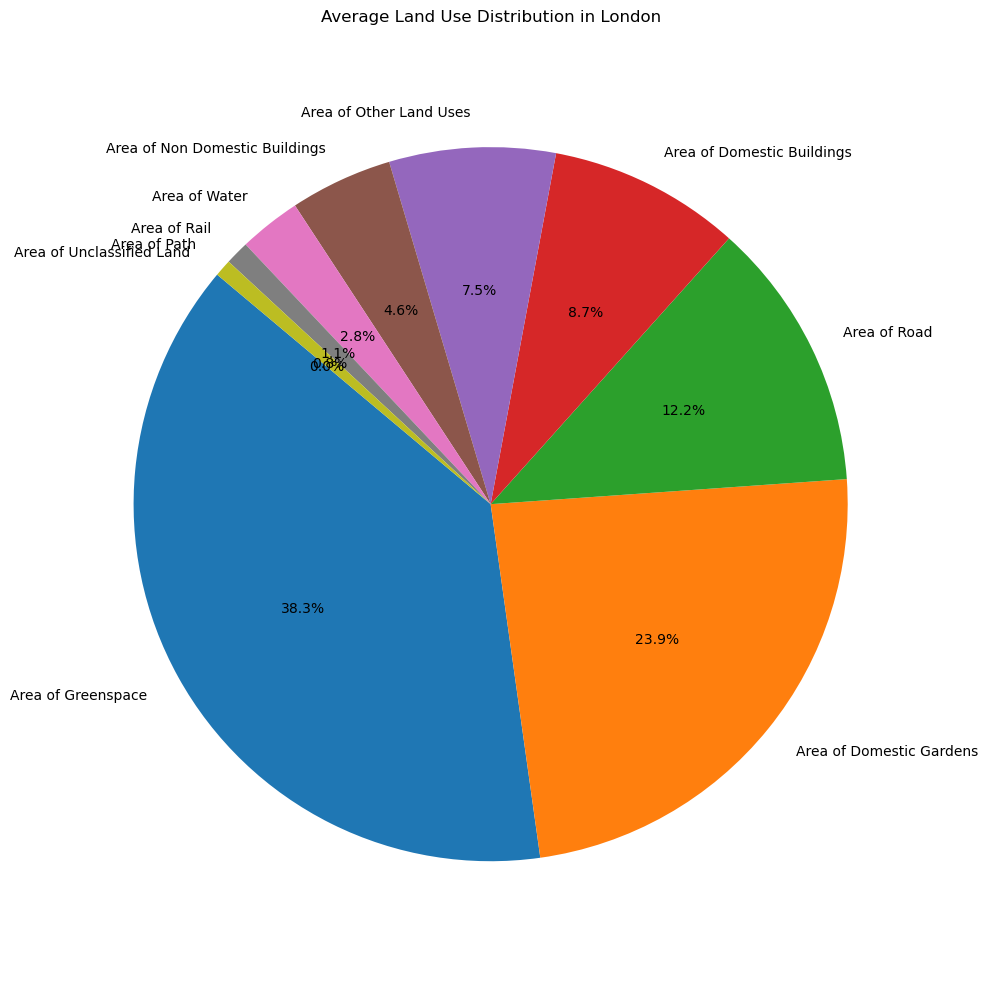

In [10]:
plt.figure(figsize=(10, 10))
plt.pie(mean_land_uses, labels=mean_land_uses.index, autopct='%1.1f%%', startangle=140)
plt.title("Average Land Use Distribution in London")
plt.axis('equal')
plt.tight_layout()
plt.show()

- **Greenspace** makes up the largest portion at **38.3%**, indicating a significant amount of natural and recreational space.
- **Domestic Gardens** follow with **23.9%**, reflecting the suburban character of many residential areas.
- **Roads (12.2%)** and **Domestic Buildings (8.7%)** make up much of the built environment.
- Other uses such as **Non-Domestic Buildings, Water, Rail, Paths, and Unclassified Land** account for smaller shares.
- This distribution highlights London's mix of green space and residential land, with moderate urban infrastructure.

## 4. Zoning with K-Means Clustering


### 4.1 Why K-Means?
- No labeled zoning categories exist → **unsupervised learning is appropriate**.
- We aim to group similar land use patterns.
- K-Means is a straightforward and effective clustering method for numeric data.

### 4.2 Prepare Features


In [11]:
# Select percentage-based land use columns
percent_columns = [col for col in df_cleaned.columns if col.startswith('% Area')]
df_cluster = df_cleaned[percent_columns].dropna()

Only percentage-based land use columns were selected in the K-Means clustering analysis to ensure size-invariant comparisons across wards. This selection enabled the detection of meaningful patterns in how land is proportionally allocated, rather than clustering based on the total size of each ward. This approach was adopted to promote interpretability and fairness in the clustering outcomes.

### 4.3. Feature Scaling

In [12]:
# Standardize the data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned[percent_columns])

In [13]:
X_scaled_df = pd.DataFrame(X_scaled, columns=percent_columns)
X_scaled_df.head()

,% Area of Domestic Buildings,% Area of Domestic Gardens,% Area of Non Domestic Buildings,% Area of Road,% Area of Rail,% Area of Path,% Area of Greenspace,% Area of Water,% Area of Other Land Uses,% Area of Unclassified Land
0,-0.060192,-0.900690,0.396700,0.500340,2.132175,1.937470,-0.393314,0.016826,1.189230,-0.040129
1,-0.118329,1.324847,-0.684973,-0.456852,0.252529,-0.856439,-0.206473,-0.313854,-0.740374,-0.040129
2,0.637442,1.889536,-0.558777,0.783952,-0.564708,-0.546005,-1.231084,-0.313854,-0.623428,-0.040129
3,-1.281053,-0.900690,-0.865251,-1.414043,-0.564708,-0.390788,2.288757,-0.264252,-0.857320,-0.040129
4,-1.106645,-0.610041,-0.306387,-1.360866,-0.196952,0.385298,1.173739,0.463244,0.097737,-0.040129


Standardization is important because K-Means is sensitive to scale. Therefore, z-score normalization (mean = 0, standard deviation = 1) was applied to ensure fair comparisons across features.

### 4.4. Determine Optimal Number of Clusters (Elbow Method)


In [14]:
# Ensure clean slate
inertias = []
k_values = list(range(1, 13))

In [15]:
# Compute inertia for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X_scaled)
    inertias.append(model.inertia_)    
# Check that both lists have the same length
print(f"k_values: {len(k_values)} | inertias: {len(inertias)}")

k_values: 12 | inertias: 12


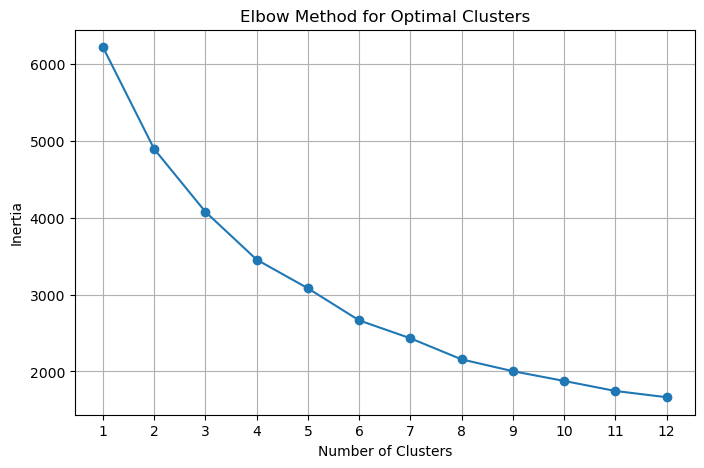

In [16]:
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.xticks(k_values)
plt.show()

Based on the elbow method, the optimal number of clusters appears to be k = 4, as this is the point where the inertia begins to level off. However, to capture more nuanced patterns within the data and allow for a finer segmentation of clusters, proceeding with __k = 6__ was chosen as the preferred approach. This decision aims to provide a more detailed understanding of the underlying structure, even if it introduces slightly more complexity.


### 4.5. Apply K-Means Clustering (k=6)

In [17]:
# Apply KMeans with k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels_6 = kmeans_6.fit_predict(X_scaled)

In [18]:
# Assign cluster labels to a new DataFrame
df_with_labels_6 = df_cleaned.loc[df_cluster.index].copy()
df_with_labels_6['Cluster'] = cluster_labels_6

In [19]:

# Cluster sizes
cluster_counts_6 = df_with_labels_6['Cluster'].value_counts().sort_index()

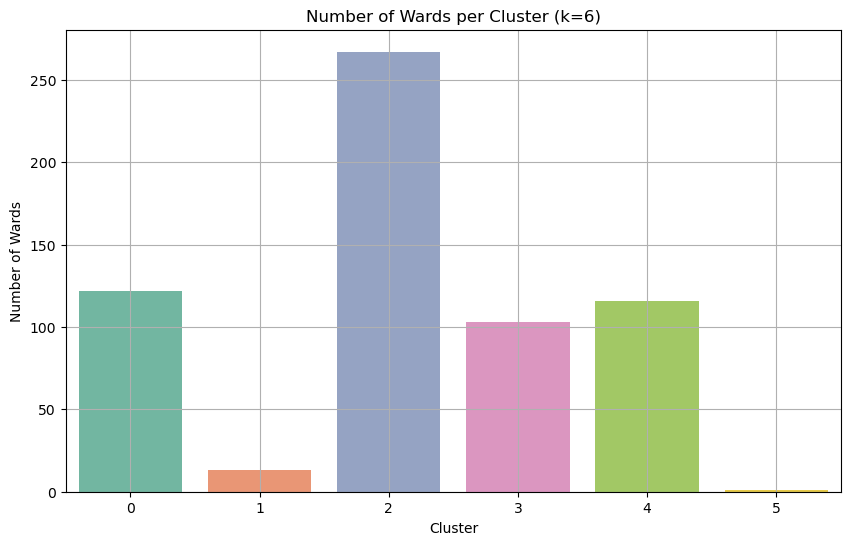

Cluster
0    122
1     13
2    267
3    103
4    116
5      1
Name: count, dtype: int64


In [20]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts_6.index, y=cluster_counts_6.values, palette='Set2')
plt.title('Number of Wards per Cluster (k=6)')
plt.xlabel('Cluster')
plt.ylabel('Number of Wards')
plt.grid(True)
plt.show()

print(cluster_counts_6)

With 6 clusters, a moderate level of segmentation is achieved—more detailed than 4 clusters but less fragmented than 10. This number is considered a suitable balance for understanding key urban types in London. Notably, **Cluster 2 was identified as the most populated group**, representing a large number of wards with balanced, mixed-use land compositions.

In [21]:
df_with_labels_6.head()

,Area Code,Local Authority Name,Area name,Area of Domestic Buildings,Area of Domestic Gardens,Area of Non Domestic Buildings,Area of Road,Area of Rail,Area of Path,Area of Greenspace,...,% Area of Road,% Area of Rail,% Area of Path,% Area of Greenspace,% Area of Water,% Area of Other Land Uses,% Area of Unclassified Land,% Total Area of All Land Types,Quality of Fit Indicator,Cluster
1,00ABFX,Barking and Dagenham,Abbey,149.04,198.92,112.17,243.22,84.44,28.06,255.31,...,18.9,6.6,2.2,19.8,2.0,14.7,0.0,100.0,0.57,0
2,00ABFY,Barking and Dagenham,Alibon,153.87,575.82,37.20,184.36,27.01,5.29,311.80,...,13.5,2.0,0.4,22.9,0.0,4.8,0.0,100.0,-0.01,2
3,00ABFZ,Barking and Dagenham,Becontree,193.96,626.05,43.68,260.83,0.00,7.31,74.92,...,20.5,0.0,0.6,5.9,0.0,5.4,0.0,100.0,-0.69,2
4,00ABGA,Barking and Dagenham,Chadwell Heath,205.58,602.38,64.79,315.29,0.00,26.09,2505.92,...,8.1,0.0,0.7,64.3,0.3,4.2,0.0,100.0,15.26,4
5,00ABGB,Barking and Dagenham,Eastbrook,215.23,658.46,166.35,292.75,30.18,41.68,1588.78,...,8.4,0.9,1.2,45.8,4.7,9.1,0.0,100.0,0.53,4


## 5. Spatial Merge and Cluster Map

In [22]:
# Load shapefile with ward boundaries
gdf = gpd.read_file("LOAC.shp")

In [23]:
gdf.head()

,OA11CD,LSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,LSOA11NM,USUALRES,HHOLDRES,...,HHOLDS,AVHHOLDSZ,PunCare,PLMTACT,area,OA,Sub,Super,Group,geometry
0,E00023264,E01004612,E05000626,Tooting,E09000032,Wandsworth,E12000007,Wandsworth 032C,462,459,...,143,3.2,42.0,15.36,0.041,E00023264,C3d,C,C3,"POLYGON ((527635.452 171810.058, 527495.957 17..."
1,E00003359,E01000692,E05000111,Chislehurst,E09000006,Bromley,E12000007,Bromley 002D,269,259,...,133,1.9,24.0,12.64,0.073,E00003359,F1a,F,F1,"POLYGON ((543581.516 171132.486, 543704.000 17..."
2,E00023266,E01004615,E05000626,Tooting,E09000032,Wandsworth,E12000007,Wandsworth 034B,277,277,...,133,2.1,26.0,25.27,0.015,E00023266,B1a,B,B1,"POLYGON ((526613.539 171839.165, 526546.840 17..."
3,E00020264,E01004027,E05000548,Riverside,E09000028,Southwark,E12000007,Southwark 003E,415,415,...,191,2.2,22.0,13.98,0.044,E00020264,B3a,B,B3,"POLYGON ((533563.521 179695.146, 533351.118 17..."
4,E00023263,E01004613,E05000626,Tooting,E09000032,Wandsworth,E12000007,Wandsworth 033D,304,304,...,131,2.3,22.0,15.46,0.019,E00023263,G1b,G,G1,"POLYGON ((527822.000 172020.000, 527979.000 17..."


To successfully join the shapefile data with the land use dataset from the CSV, the column names containing ward names were first standardized. The shapefile originally used **"WD11NM_BF"** as the ward name field, while the CSV used **"Area name"**. The column in the shapefile was renamed to ensure that both datasets shared a common key for merging.


In [24]:
# Rename shapefile's ward name column to match CSV
gdf = gdf.rename(columns={"WD11NM_BF": "Area name"})

In [25]:
# Perform merge on ward name
merged_gdf = gdf.merge(df_with_labels_6[['Area name', 'Cluster']], on="Area name", how="inner")

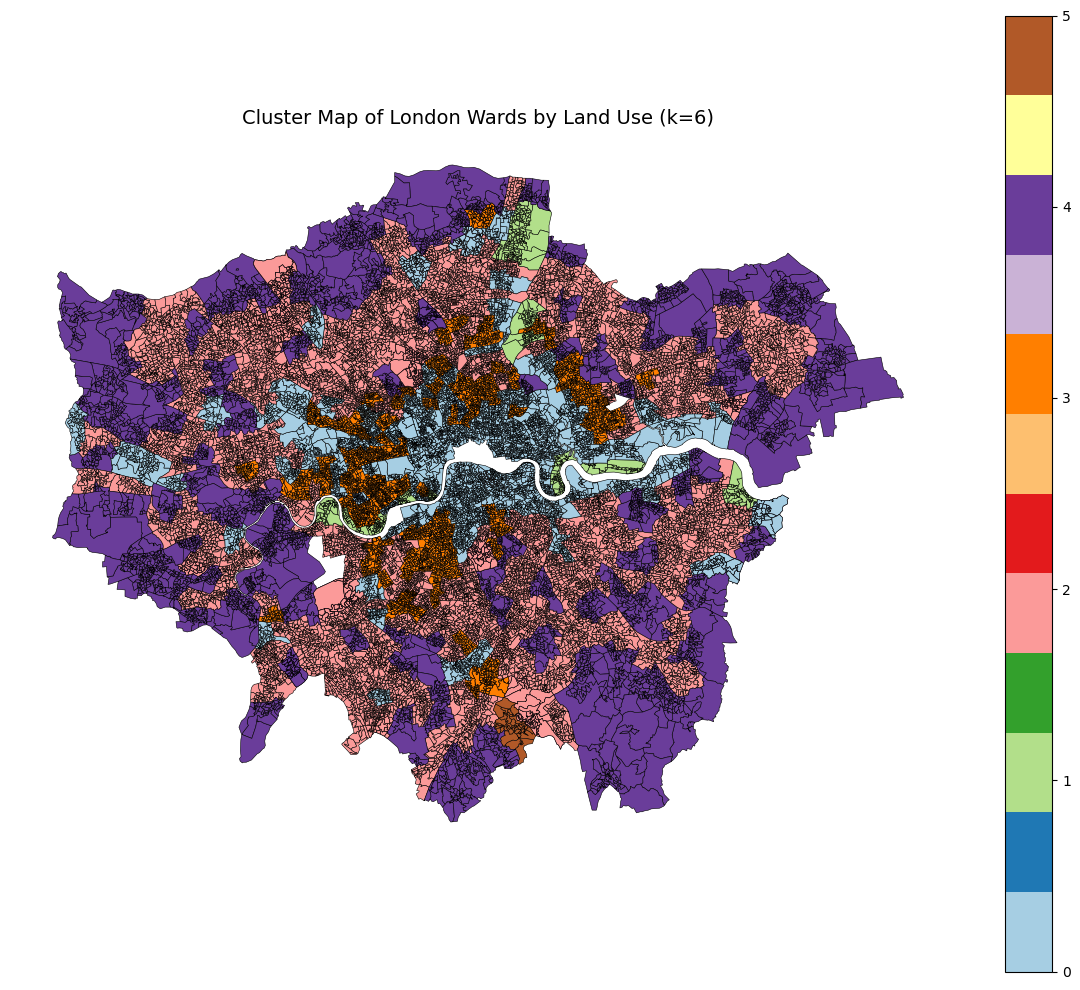

In [26]:
# Cluster Map visualization
fig, ax = plt.subplots(figsize=(12, 10))
merged_gdf.plot(column="Cluster",
                cmap="Paired",
                legend=True,
                linewidth=0.4,
                edgecolor="black",
                ax=ax)

ax.set_title("Cluster Map of London Wards by Land Use (k=6)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

This map provides a spatial understanding of the 6 land use-based clusters across London's wards. Each color represents a distinct cluster characterized by a unique mix of land use types such as residential, commercial, greenspace, and transport infrastructure. 


## 6. Cluster Profiles and Interpretation

In [27]:
# Calculate average percentage values per cluster
cluster_features = df_with_labels_6.groupby("Cluster")[percent_columns].mean().round(2)
display(cluster_features)

,% Area of Domestic Buildings,% Area of Domestic Gardens,% Area of Non Domestic Buildings,% Area of Road,% Area of Rail,% Area of Path,% Area of Greenspace,% Area of Water,% Area of Other Land Uses,% Area of Unclassified Land
Cluster,,,,,,,,,,
0,10.66,13.20,13.77,19.50,2.91,1.50,20.26,2.54,15.65,0.0
1,6.50,10.47,6.06,9.74,0.46,0.70,19.39,35.75,10.89,0.0
2,12.22,36.00,3.91,15.31,1.19,0.82,23.34,0.71,6.49,0.0
3,20.04,26.35,8.94,23.01,1.15,0.98,10.76,0.19,8.57,0.0
4,5.96,19.71,2.74,8.88,0.53,0.70,53.92,1.70,5.86,0.0
5,5.30,29.00,0.90,6.60,0.00,0.30,55.60,0.00,2.20,0.2


This table shows the average land use composition for each cluster. It provides a data-driven foundation for interpreting the spatial and functional character of each cluster, such as which ones are park-dominant, residential, transport-oriented, or mixed-use. The subsequent interpretation section builds directly on these statistical patterns.


## Summary:

## Cluster Interpretation and Evaluation

###  Data-Driven Summary of Cluster Characteristics
The following interpretations are based on the observed average land use percentages for each cluster:

- **Cluster 0 — Mixed-Use Activity Zone**
  - High % of Non-Domestic Buildings (13.77%), Roads (19.50%), and Other Land Uses (15.65%)  
  - Reflects transitional or commercial zones with varied land functions such as offices, industry, or large facilities.  
  - Moderate greenspace (20.26%) suggests limited residential or natural presence.
  
- **Cluster 1 — Waterfront Areas**
  - Very high % Water (35.75%) with moderate Greenspace (19.39%)  
  - Likely includes wards adjacent to the Thames River, reservoirs, or large bodies of water.  
  - Built environment components are minimal, reflecting riverside or marina character.

- **Cluster 2 — Garden-Suburban Areas**
  - Highest % of Domestic Gardens (36.00%) and significant Greenspace (23.34%)  
  - Typical of low-to-mid density suburban residential areas with private gardens and open space.  
  - Built environment is balanced and moderate.

- **Cluster 3 — Dense Urban Core**
  - Highest % of Domestic Buildings (20.04%) and Roads (23.01%)  
  - Among the lowest Greenspace (10.76%)  
  - Clearly represents compact, inner-city zones with intense built infrastructure.

- **Cluster 4 — Greenbelt Zones**
  - Very high % Greenspace (53.92%) and Domestic Gardens (19.71%)  
  - These wards likely lie on the urban fringe, encompassing natural areas, parks, or protected land.

- **Cluster 5 — Exceptionally Unique: Selsdon and Ballards** 

  - This cluster contains **only one ward: "Selsdon and Ballards"**
      - Surrounded by **Selsdon Wood**, a 200-acre National Trust woodland
      - Contains **Selsdon Park Hotel**, a historical estate formerly with a golf course
  - Highest % Greenspace (55.60%) and high Domestic Gardens (29.00%)  
  - Possibly unique green enclaves, golf courses, or environmentally preserved areas  
  - Minimal built-up area suggests exceptional ecological or recreational value. 
 -----
- K-Means clustering was applied to classify London wards into six spatially distinct urban typologies based on detailed land use compositions.
- The clustering produced a balance between interpretability and granularity, allowing us to identify core urban, suburban, commercial, and ecological zone patterns.  
- These clusters were visualized through a spatial map and numerically summarized using average percentage metrics for key land types.
